In [28]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
# Read the data
sample_submission_file = pd.read_csv("sample_submission.csv")
train_data = pd.read_csv('train.csv', index_col='Id')
X_test = pd.read_csv('test.csv', index_col='Id')
X = train_data.copy()

In [31]:
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In this notebook I'll practice **pipeline** and **cross-validation** on the Housing Prices Dataset for Kaggle Learn Users. The challenge is to create a model of **house price prediction**.

# 1. Quick Data Analysis

At first we should try to minimise the skew of the dataset. The reason given is that skewed data adversely affects the prediction accuracy of regression models. 

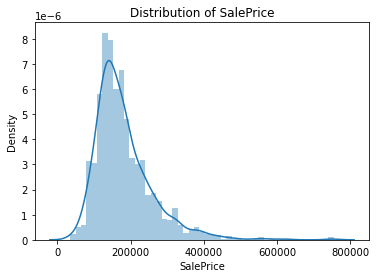

In [32]:
plt.figure()
sns.distplot(X.SalePrice)
plt.title('Distribution of SalePrice')
plt.show()

The **log-transformed** SalePrice improves the skew.

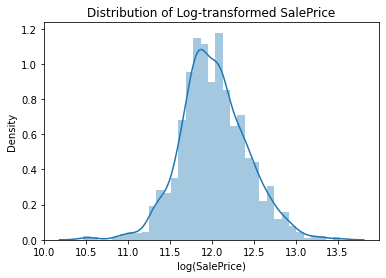

In [33]:
sns.distplot(np.log(X.SalePrice))
plt.title('Distribution of Log-transformed SalePrice')
plt.xlabel('log(SalePrice)')
plt.show()

In [34]:
# Perform log transformation on SalePrice

X['SalePrice'] = np.log(X['SalePrice'])
X = X.rename(columns={'SalePrice': 'SalePrice_log'})

In [35]:
# Separate target from predictors
y = X.SalePrice_log

Let's check the correlation of the numerical columns.

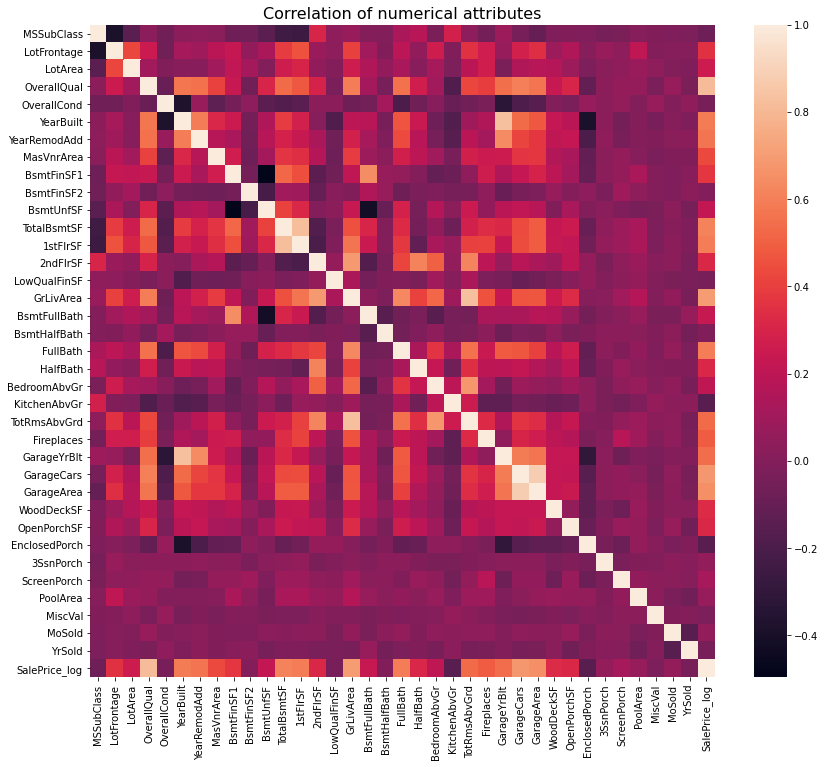

In [36]:
correlation = X.corr()

f, ax = plt.subplots(figsize=(14,12))
plt.title('Correlation of numerical attributes', size=16)
sns.heatmap(correlation)
plt.show()

In [37]:
# Top correlated attributes to the target SalePrice_log
round(correlation['SalePrice_log'].sort_values(ascending=False).head(15), 2)

SalePrice_log    1.00
OverallQual      0.82
GrLivArea        0.70
GarageCars       0.68
GarageArea       0.65
TotalBsmtSF      0.61
1stFlrSF         0.60
FullBath         0.59
YearBuilt        0.59
YearRemodAdd     0.57
GarageYrBlt      0.54
TotRmsAbvGrd     0.53
Fireplaces       0.49
MasVnrArea       0.43
BsmtFinSF1       0.37
Name: SalePrice_log, dtype: float64

Top correlation attributes to the Sale Price are:

1. **GrLivArea**: Above grade (ground) living area square feet
1. **OverallQual**: Overall material and finish quality
1. **GarageCars**: Size of garage in car capacity

We can exclude **GarageArea** because it's highly correlated with **GarageCars**, which has a higher correlation with **SalePrice_log**.

In most cases house and garage are built in the same year thus we can exclude **GarageYrBlt**.

We can aslo exclude attributes with low or unclear correlation with SalePrice_log: **MSSubClass**, **MoSold**, **YrSold**, **MiscVal**.

In [38]:
# Remove attributes that were identified for excluding when viewing corr values
attributes_drop = ['MiscVal', 'MSSubClass', 'MoSold', 'YrSold', 
                   'GarageArea', 'GarageYrBlt']

In [39]:
X.drop(attributes_drop, axis=1, inplace=True)

In [40]:
X.drop('SalePrice_log', axis=1, inplace=True)

In [41]:
X.head()

,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,RFn,2,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,WD,Normal
2,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,RFn,2,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,WD,Normal
3,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,RFn,2,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,WD,Normal
4,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,Unf,3,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,WD,Abnorml
5,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,RFn,3,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,WD,Normal


# 2. Data preprocessing

In [42]:
# X and X_test should have the same columns
X_test.drop(attributes_drop, axis=1, inplace=True)

In [43]:
# Numerical and categorical columns shoud be treated separately
num_columns = X.select_dtypes(exclude='object').columns
cat_columns = X.select_dtypes(include='object').columns

In [44]:
# Imputation to null values of these numerical columns need to be 'constant'
constant_num_cols = ['MasVnrArea']

# Imputation to null values of these numerical columns need to be 'mean'
mean_num_cols = list(set(num_columns).difference(set(constant_num_cols)))

# Imputation to null values of these categorical columns need to be 'constant'
constant_categorical_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
                     'GarageCond', 'GarageQual', 'GarageFinish', 'GarageType',
                     'BsmtFinType2', 'BsmtExposure', 'BsmtFinType1', 'BsmtQual', 'BsmtCond',
                     'MasVnrType']

# Imputation to null values of these categorical columns need to be 'most_frequent'
mf_categorical_cols = list(set(cat_columns).difference(set(constant_categorical_cols)))

my_cols = constant_num_cols + mean_num_cols + constant_categorical_cols + mf_categorical_cols

In [45]:
# Define transformers
# Preprocessing for numerical data

numerical_transformer_m = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

numerical_transformer_c = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())])


# Preprocessing for categorical data for most frequent
categorical_transformer_mf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore', sparse = False))
])

# Preprocessing for categorical data for constant
categorical_transformer_c = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore', sparse = False))
])


# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num_mean', numerical_transformer_m, mean_num_cols),
        ('num_constant', numerical_transformer_c, constant_num_cols),
        ('cat_mf', categorical_transformer_mf, mf_categorical_cols),
        ('cat_c', categorical_transformer_c, constant_categorical_cols)
    ])

In [46]:
# Preprocessing of training data
X_cv = X[my_cols].copy()
X_sub = X_test[my_cols].copy()

In [47]:
X_cv.head()

,MasVnrArea,EnclosedPorch,OverallQual,YearRemodAdd,TotalBsmtSF,1stFlrSF,LotFrontage,BedroomAbvGr,GrLivArea,YearBuilt,OpenPorchSF,HalfBath,PoolArea,WoodDeckSF,LotArea,3SsnPorch,TotRmsAbvGrd,2ndFlrSF,Fireplaces,ScreenPorch,LowQualFinSF,BsmtFinSF1,BsmtHalfBath,OverallCond,BsmtFinSF2,BsmtUnfSF,BsmtFullBath,KitchenAbvGr,FullBath,GarageCars,PoolQC,MiscFeature,Alley,Fence,FireplaceQu,GarageCond,GarageQual,GarageFinish,GarageType,BsmtFinType2,BsmtExposure,BsmtFinType1,BsmtQual,BsmtCond,MasVnrType,LandContour,LandSlope,RoofMatl,Heating,Functional,SaleCondition,MSZoning,Foundation,PavedDrive,SaleType,Exterior2nd,ExterQual,Street,HouseStyle,CentralAir,Condition2,Utilities,LotShape,Exterior1st,RoofStyle,Condition1,ExterCond,HeatingQC,Electrical,Neighborhood,KitchenQual,BldgType,LotConfig
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,196.0,0,7,2003,856,856,65.0,3,1710,2003,61,1,0,0,8450,0,8,854,0,0,0,706,0,5,0,150,1,1,2,2,NaN,NaN,NaN,NaN,NaN,TA,TA,RFn,Attchd,Unf,No,GLQ,Gd,TA,BrkFace,Lvl,Gtl,CompShg,GasA,Typ,Normal,RL,PConc,Y,WD,VinylSd,Gd,Pave,2Story,Y,Norm,AllPub,Reg,VinylSd,Gable,Norm,TA,Ex,SBrkr,CollgCr,Gd,1Fam,Inside
2,0.0,0,6,1976,1262,1262,80.0,3,1262,1976,0,0,0,298,9600,0,6,0,1,0,0,978,1,8,0,284,0,1,2,2,NaN,NaN,NaN,NaN,TA,TA,TA,RFn,Attchd,Unf,Gd,ALQ,Gd,TA,None,Lvl,Gtl,CompShg,GasA,Typ,Normal,RL,CBlock,Y,WD,MetalSd,TA,Pave,1Story,Y,Norm,AllPub,Reg,MetalSd,Gable,Feedr,TA,Ex,SBrkr,Veenker,TA,1Fam,FR2
3,162.0,0,7,2002,920,920,68.0,3,1786,2001,42,1,0,0,11250,0,6,866,1,0,0,486,0,5,0,434,1,1,2,2,NaN,NaN,NaN,NaN,TA,TA,TA,RFn,Attchd,Unf,Mn,GLQ,Gd,TA,BrkFace,Lvl,Gtl,CompShg,GasA,Typ,Normal,RL,PConc,Y,WD,VinylSd,Gd,Pave,2Story,Y,Norm,AllPub,IR1,VinylSd,Gable,Norm,TA,Ex,SBrkr,CollgCr,Gd,1Fam,Inside
4,0.0,272,7,1970,756,961,60.0,3,1717,1915,35,0,0,0,9550,0,7,756,1,0,0,216,0,5,0,540,1,1,1,3,NaN,NaN,NaN,NaN,Gd,TA,TA,Unf,Detchd,Unf,No,ALQ,TA,Gd,None,Lvl,Gtl,CompShg,GasA,Typ,Abnorml,RL,BrkTil,Y,WD,Wd Shng,TA,Pave,2Story,Y,Norm,AllPub,IR1,Wd Sdng,Gable,Norm,TA,Gd,SBrkr,Crawfor,Gd,1Fam,Corner
5,350.0,0,8,2000,1145,1145,84.0,4,2198,2000,84,1,0,192,14260,0,9,1053,1,0,0,655,0,5,0,490,1,1,2,3,NaN,NaN,NaN,NaN,TA,TA,TA,RFn,Attchd,Unf,Av,GLQ,Gd,TA,BrkFace,Lvl,Gtl,CompShg,GasA,Typ,Normal,RL,PConc,Y,WD,VinylSd,Gd,Pave,2Story,Y,Norm,AllPub,IR1,VinylSd,Gable,Norm,TA,Ex,SBrkr,NoRidge,Gd,1Fam,FR2


# 3. Choosing a model and saving results

In [48]:
# Test different models

from xgboost import XGBRegressor

xgb_model = XGBRegressor(learning_rate = 0.05,
                            n_estimators=1000,
                            max_depth=5,
                            min_child_weight=2,
                            gamma=0,
                            subsample=0.7,
                            colsample_bytree=0.7,
                            reg_alpha = 0,
                            reg_lambda = 1,
                            random_state=0)

# Create the Pipeline
# Bundle preprocessing and modeling code in a pipeline
my_pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', xgb_model)
                             ])

# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(my_pipeline_xgb, X_cv, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE score:\n", scores)
print("MAE mean: {}".format(scores.mean()))

MAE score:
 [0.07828202 0.0853554  0.08547912 0.07863603 0.08064112]
MAE mean: 0.08167873773807718


In [49]:
from sklearn.linear_model import Lasso

lasso_model = Lasso(alpha=0.0005, random_state=0)

my_pipeline_lasso = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', lasso_model)
                             ])

scores = -1 * cross_val_score(my_pipeline_lasso, X_cv, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE score:\n", scores)
print("MAE mean: {}".format(scores.mean()))

MAE score:
 [0.08021559 0.08449011 0.08288089 0.07892497 0.08809375]
MAE mean: 0.0829210601435943


In [50]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=0.002, random_state=5)

my_pipeline_ridge = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', ridge_model)
                             ])

scores = -1 * cross_val_score(my_pipeline_ridge, X_cv, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE score:\n", scores)
print("MAE mean: {}".format(scores.mean()))

MAE score:
 [0.0905965  0.09421522 0.09478576 0.07989056 0.09426279]
MAE mean: 0.09075016616551526


**XGBRegressor** delivers the lowest mean absolute error, the target is still SalePrice_log and not SalePrice.

We can play with models and **try different settings**, the alternative to it is of course **GridSearchCV**.